In [1]:
# =============================================================================
# Title   : Fuzzy Logic Portfolio — Environment & Energy (3 Examples)
# Course  : Models and Methods of Intelligent Systems
# Topic   : Water Quality, Demand Response, Environmental Risk (Mamdani FIS)
# Author  : Dr.-Ing. Cesar Hernando Valencia Niño
# Date    : 2026-01-27
# =============================================================================

# =========================
# Install & Imports
# =========================
!pip -q install scikit-fuzzy ipywidgets
import numpy as np, matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass
print("Setup complete.")

# =========================
# Helper Utilities
# =========================
def plot_mfs(variable, title_suffix=""):
    plt.figure()
    for term_name, term_obj in variable.terms.items():
        plt.plot(variable.universe, term_obj.mf, label=term_name)
    plt.title(f"Membership Functions — {variable.label} {title_suffix}".strip())
    plt.xlabel(variable.label); plt.ylabel("Membership degree")
    plt.ylim(-0.05, 1.05); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

def report_system(title, antecedents, consequents, rules):
    print("\n" + "="*80); print(title); print("="*80)
    def _describe(v):
        u = v.universe
        print(f"\nVariable: {v.label}")
        print(f"  Universe: [{float(u.min()):.4f}, {float(u.max()):.4f}] | Points: {len(u)}")
        print("  Fuzzy sets (terms):")
        for t in v.terms.keys(): print(f"    - {t}")
    print("\n--- Antecedents (Inputs) ---")
    for a in antecedents: _describe(a)
    print("\n--- Consequents (Outputs) ---")
    for c in consequents: _describe(c)
    print("\n--- Rule Base ---")
    for i, r in enumerate(rules, 1): print(f"{i:02d}. {str(r)}")

def build_dashboard(system, inputs_spec, output_name, title):
    sim = ctrl.ControlSystemSimulation(system)
    sliders = {name: FloatSlider(value=v0, min=vmin, max=vmax, step=step,
                                 description=name, continuous_update=False)
               for (name, vmin, vmax, step, v0) in inputs_spec}
    display(HTML(f"<h3 style='margin:6px 0'>{title}</h3>"))
    def _run(**kwargs):
        for k, v in kwargs.items(): sim.input[k] = float(v)
        sim.compute()
        y = float(sim.output[output_name])
        print(f"{output_name} (defuzzified) = {y:.6f}")
        return y
    interact(_run, **sliders)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.5 MB/s eta 0:00:00
Setup complete.



Example 1 — Water Quality (turbidity, ph_dev → wqi)

--- Antecedents (Inputs) ---

Variable: turbidity
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

Variable: ph_dev
  Universe: [0.0000, 2.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

--- Consequents (Outputs) ---

Variable: wqi
  Universe: [0.0000, 100.0000] | Points: 201
  Fuzzy sets (terms):
    - poor
    - fair
    - good

--- Rule Base ---
01. IF turbidity[low] AND ph_dev[low] THEN wqi[good]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF turbidity[high] AND ph_dev[low] THEN wqi[fair]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF turbidity[low] AND ph_dev[high] THEN wqi[fair]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF turbidity[high] AND ph_dev[high] THEN wqi[poor]
	AND aggregation function : fmin
	OR aggregation function  : fmax


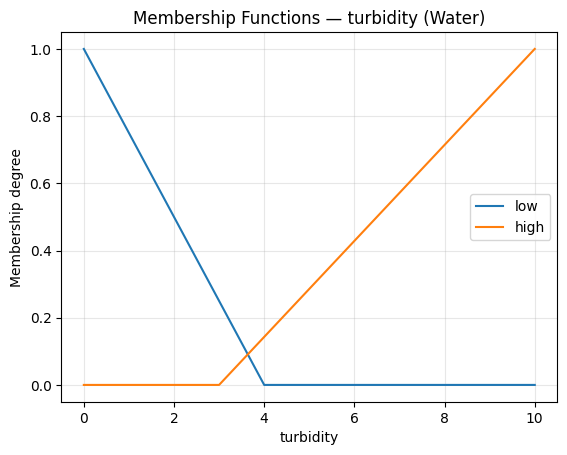

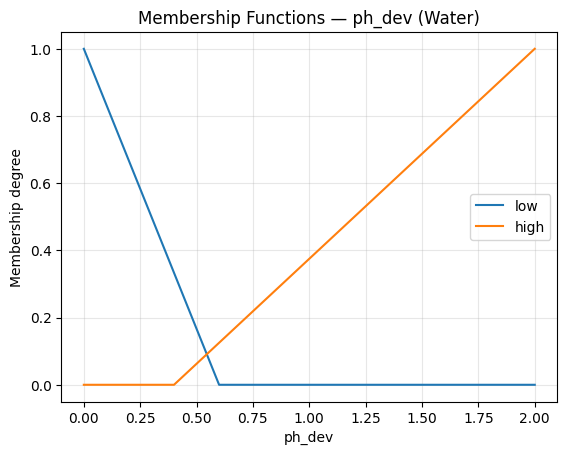

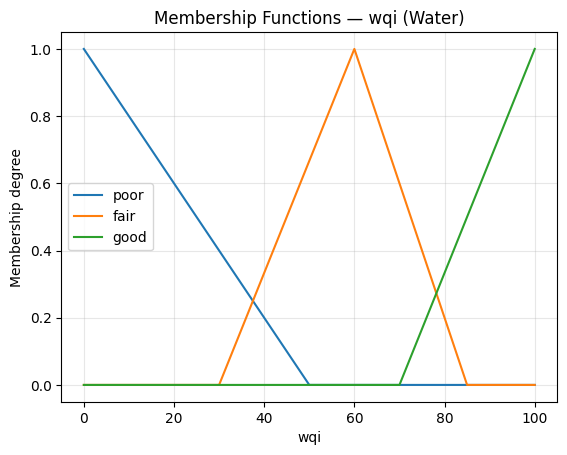

HTML(value="<h3 style='margin:6px 0'>Example 1 — Water Quality Dashboard</h3>")

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='turbidity', max=10.0), Floa…

In [2]:
# Example 1 — Water Quality Index
turbidity = ctrl.Antecedent(np.linspace(0, 10, 201), 'turbidity')
ph_dev = ctrl.Antecedent(np.linspace(0, 2, 201), 'ph_dev')  # |pH-7|
wqi = ctrl.Consequent(np.linspace(0, 100, 201), 'wqi')      # higher = better

turbidity['low'] = fuzz.trimf(turbidity.universe, [0, 0, 4])
turbidity['high'] = fuzz.trimf(turbidity.universe, [3, 10, 10])

ph_dev['low'] = fuzz.trimf(ph_dev.universe, [0, 0, 0.6])
ph_dev['high'] = fuzz.trimf(ph_dev.universe, [0.4, 2, 2])

wqi['poor'] = fuzz.trimf(wqi.universe, [0, 0, 50])
wqi['fair'] = fuzz.trimf(wqi.universe, [30, 60, 85])
wqi['good'] = fuzz.trimf(wqi.universe, [70, 100, 100])

rules = [
    ctrl.Rule(turbidity['low'] & ph_dev['low'], wqi['good']),
    ctrl.Rule(turbidity['high'] & ph_dev['low'], wqi['fair']),
    ctrl.Rule(turbidity['low'] & ph_dev['high'], wqi['fair']),
    ctrl.Rule(turbidity['high'] & ph_dev['high'], wqi['poor']),
]
system = ctrl.ControlSystem(rules)
report_system("Example 1 — Water Quality (turbidity, ph_dev → wqi)", [turbidity, ph_dev], [wqi], rules)
plot_mfs(turbidity, "(Water)"); plot_mfs(ph_dev, "(Water)"); plot_mfs(wqi, "(Water)")
build_dashboard(system, [('turbidity', 0, 10, 0.1, 3.0), ('ph_dev', 0, 2, 0.01, 0.3)],
                'wqi', "Example 1 — Water Quality Dashboard")


Example 2 — Demand Response (demand, price → curtail)

--- Antecedents (Inputs) ---

Variable: demand
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

Variable: price
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

--- Consequents (Outputs) ---

Variable: curtail
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Rule Base ---
01. IF demand[low] THEN curtail[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF demand[high] AND price[low] THEN curtail[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF demand[high] AND price[high] THEN curtail[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax


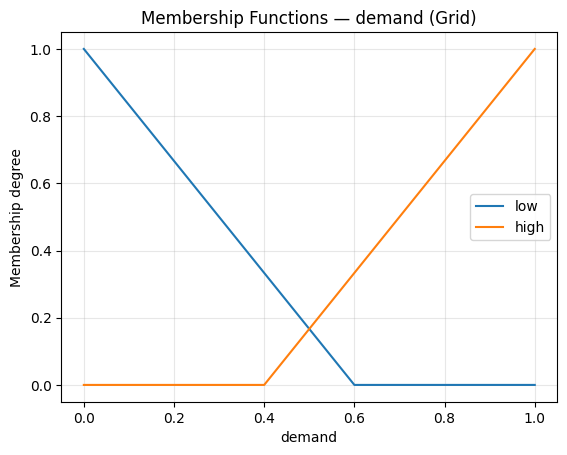

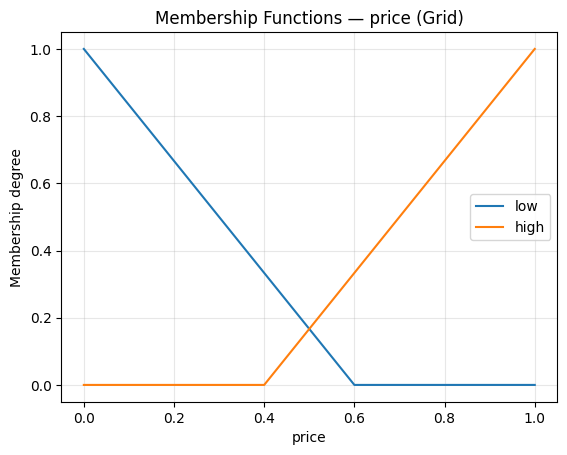

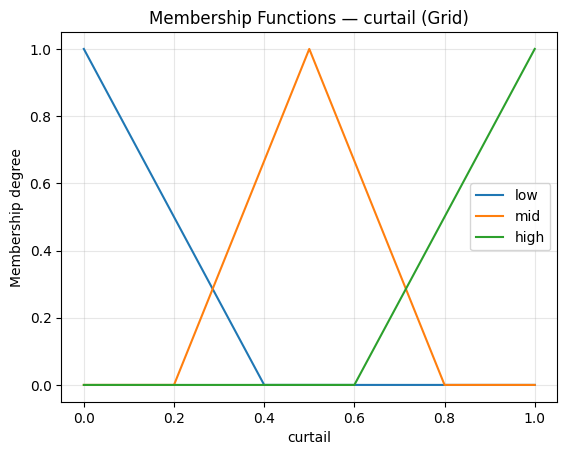

HTML(value="<h3 style='margin:6px 0'>Example 2 — Demand Response Dashboard</h3>")

interactive(children=(FloatSlider(value=0.7, continuous_update=False, description='demand', max=1.0, step=0.01…

In [3]:
# Example 2 — Demand Response
demand = ctrl.Antecedent(np.linspace(0, 1, 201), 'demand')
price = ctrl.Antecedent(np.linspace(0, 1, 201), 'price')
curtail = ctrl.Consequent(np.linspace(0, 1, 201), 'curtail')

for v in [demand, price]:
    v['low'] = fuzz.trimf(v.universe, [0, 0, 0.6])
    v['high'] = fuzz.trimf(v.universe, [0.4, 1, 1])

curtail['low'] = fuzz.trimf(curtail.universe, [0, 0, 0.4])
curtail['mid'] = fuzz.trimf(curtail.universe, [0.2, 0.5, 0.8])
curtail['high'] = fuzz.trimf(curtail.universe, [0.6, 1, 1])

rules = [
    ctrl.Rule(demand['low'], curtail['low']),
    ctrl.Rule(demand['high'] & price['low'], curtail['mid']),
    ctrl.Rule(demand['high'] & price['high'], curtail['high']),
]
system = ctrl.ControlSystem(rules)
report_system("Example 2 — Demand Response (demand, price → curtail)", [demand, price], [curtail], rules)
plot_mfs(demand, "(Grid)"); plot_mfs(price, "(Grid)"); plot_mfs(curtail, "(Grid)")
build_dashboard(system, [('demand', 0, 1, 0.01, 0.7), ('price', 0, 1, 0.01, 0.8)],
                'curtail', "Example 2 — Demand Response Dashboard")


Example 3 — Environmental Risk (exposure, sensitivity → env_risk)

--- Antecedents (Inputs) ---

Variable: exposure
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

Variable: sensitivity
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

--- Consequents (Outputs) ---

Variable: env_risk
  Universe: [0.0000, 10.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - mid
    - high

--- Rule Base ---
01. IF exposure[low] AND sensitivity[low] THEN env_risk[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF exposure[high] AND sensitivity[low] THEN env_risk[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF exposure[low] AND sensitivity[high] THEN env_risk[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF exposure[high] AND sensitivity[high] THEN env_risk[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax


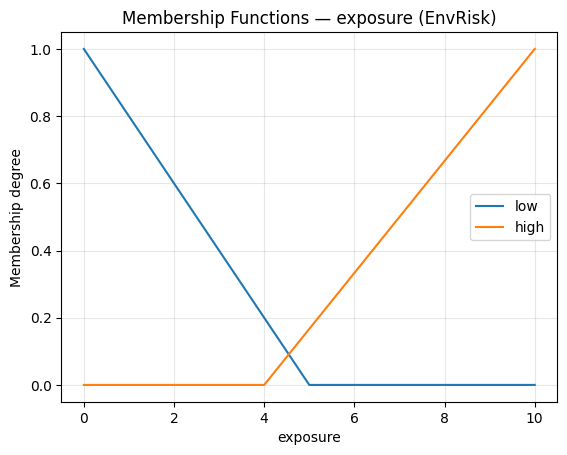

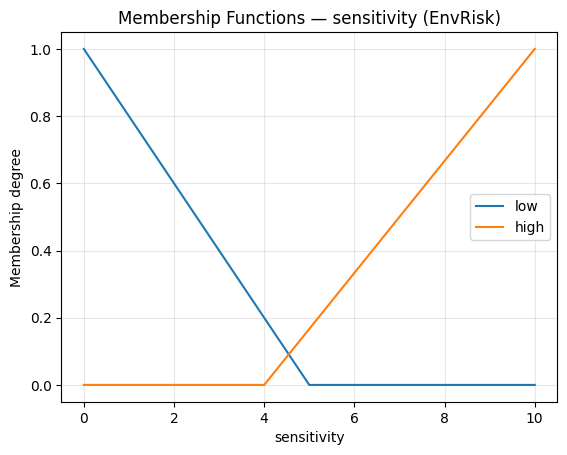

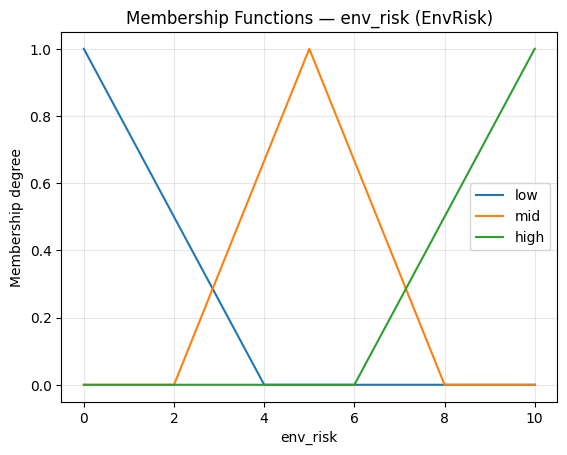

HTML(value="<h3 style='margin:6px 0'>Example 3 — Environmental Risk Dashboard</h3>")

interactive(children=(FloatSlider(value=6.0, continuous_update=False, description='exposure', max=10.0), Float…

In [4]:
# Example 3 — Environmental Risk
exposure = ctrl.Antecedent(np.linspace(0, 10, 201), 'exposure')
sensitivity = ctrl.Antecedent(np.linspace(0, 10, 201), 'sensitivity')
env_risk = ctrl.Consequent(np.linspace(0, 10, 201), 'env_risk')

for v in [exposure, sensitivity]:
    v['low'] = fuzz.trimf(v.universe, [0, 0, 5])
    v['high'] = fuzz.trimf(v.universe, [4, 10, 10])

env_risk['low'] = fuzz.trimf(env_risk.universe, [0, 0, 4])
env_risk['mid'] = fuzz.trimf(env_risk.universe, [2, 5, 8])
env_risk['high'] = fuzz.trimf(env_risk.universe, [6, 10, 10])

rules = [
    ctrl.Rule(exposure['low'] & sensitivity['low'], env_risk['low']),
    ctrl.Rule(exposure['high'] & sensitivity['low'], env_risk['mid']),
    ctrl.Rule(exposure['low'] & sensitivity['high'], env_risk['mid']),
    ctrl.Rule(exposure['high'] & sensitivity['high'], env_risk['high']),
]
system = ctrl.ControlSystem(rules)
report_system("Example 3 — Environmental Risk (exposure, sensitivity → env_risk)",
              [exposure, sensitivity], [env_risk], rules)
plot_mfs(exposure, "(EnvRisk)"); plot_mfs(sensitivity, "(EnvRisk)"); plot_mfs(env_risk, "(EnvRisk)")
build_dashboard(system, [('exposure', 0, 10, 0.1, 6.0), ('sensitivity', 0, 10, 0.1, 7.0)],
                'env_risk', "Example 3 — Environmental Risk Dashboard")